In [41]:
import altair as alt
import pandas as pd
import numpy as np

alt.renderers.enable('notebook')

df = pd.read_csv("GLB.Ts+dSST.csv", 
                   index_col=0, skiprows=8, 
                   names=['Year', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'July',
                          'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], 
                   header=None, usecols=range(13))

matrix_of_values = df.values
average_temps = np.average(matrix_of_values, axis=1)

df['years'] = df.index
df['summer'] = df[['Jun', 'July', 'Aug']].mean(axis=1)
df['autumn'] = df[['Sep', 'Oct', 'Nov']].mean(axis=1)
df['winter'] = df[['Dec', 'Jan', 'Feb']].mean(axis=1)
df['spring'] = df[['Mar', 'Apr', 'May']].mean(axis=1)
df['avg'] = average_temps


avg_col_names = ['summer_round', 'autumn_round', 'winter_round', 'spring_round', 'avg_round']
df[avg_col_names] = df.round(2)[['summer', 'autumn', 'winter', 'spring', 'avg']]

data = df[(df.years % 10 == 0) | (df.years == 2017)]

In [36]:
class SeasonChart(object):
    def __init__(self, data, selection, season, chart_config):
        self.__dict__.update(chart_config)
        
        if season == 'winter':
            y_axis_title='temperature'
        else:
            y_axis_title=''
        years_to_show = [1880, 1925 ,1970, 2017]
            
        
        default_encoding = {
            "x": alt.X(
                'years',
                scale=self.default_scales['years'],
                axis=alt.Axis(
                    format='.4',
                    title='', 
                    values=years_to_show)
                ),
            "y": alt.Y(
                season,
                scale=self.default_scales['temp'],
                axis=alt.Axis(title=y_axis_title)
            )
        }

        self.line_chart = self.get_line_chart(data, self.width, default_encoding)
        self.title = self.get_title(season)
        self.points = self.get_point(self.line_chart, selection)
        self.text = self.get_text(season, self.line_chart, selection)
        self.difference = self.get_difference(data, season)

    def __call__(self):
        return alt.layer(self.line_chart, self.title, self.points, self.text, self.difference)

    @staticmethod
    def get_line_chart(data, width, default_encoding):
        return alt.Chart(data, width=width).mark_line(color='#E63946').encode(
            **default_encoding
        )
    
    @staticmethod
    def get_title(season):
        title_df = pd.DataFrame({
            'title': [season.capitalize()],
            'y': [0.6],
            'x': [1915]
        })

        chart = alt.Chart(title_df).mark_text(
            align='center',
            baseline='middle',
            font='Oswald',
            fontSize=22,
            color='#272838'
        ).encode(
            y='y:Q',
            x='x:Q',
            text='title'
        )

        return chart

    @staticmethod
    def get_point(line_chart, selection):
        return line_chart.mark_circle(
            size=40,
            color='#E63946'
        ).transform_filter(
            selection
        )

    @staticmethod
    def get_text(season, line_chart, selection):
        return line_chart.mark_text(
            align='center', 
            dy=-10,
            dx=-10,
            baseline='top',
            font='Oswald',
            fontSize=12,
            fontWeight=600
        ).encode(
            text='{}_round'.format(season)
        ).transform_filter(
            selection
        )
    
    
    @staticmethod
    def get_difference(df, season):
        data = df[season].iloc[[0, -1]]

        temp_difference_df = pd.DataFrame({
            'labels': "+" + str((data.values[1] - data.values[0]).round(2)) + "°",
            'y': [0.4],
            'x': [1935]
        })

        return alt.Chart(temp_difference_df).mark_text(
            align='center',
            baseline='middle',
            font='Oswald',
            fontSize=20,
            color='#272838'
        ).encode(
            y='y:Q',
            x=alt.X('x:Q',
                    scale=alt.Scale(domain=(1880, 2016))
                    ),
            text='labels'
        )

In [37]:
class AverageTempChart(object):
    def __init__(self, data, selection, chart_config):
        self.__dict__.update(chart_config)
        
        years_to_show = list(range(1880,2017,10))
        years_to_show.append(2017)
        
        default_x_encoding = alt.X(
            'years',
            scale=self.default_scales['years'],
            axis=alt.Axis(
                format='.4',
                title='',
                values=years_to_show
            )
        )

        default_encoding = {
            "x": default_x_encoding,
            "y": alt.Y(
                'avg',
                scale=self.default_scales['temp']
            )
        }
        self.line_chart = self.get_line_chart(data, self.width, self.height, default_encoding)
        self.rule = self.get_rule(data, default_x_encoding, selection)
        self.selector = self.get_selector(data, default_x_encoding, selection)

    def __call__(self):
        return alt.layer(self.line_chart, self.rule, self.selector)

    @staticmethod
    def get_line_chart(data, width, height, default_encoding):
        return alt.Chart(data, width=width, height=height).mark_line(color='#E63946').encode(
            **default_encoding
        )

    @staticmethod
    def get_rule(data, default_x_encoding, selection):
        return alt.Chart(data).mark_rule().encode(
            x=default_x_encoding,
        ).transform_filter(
            selection
        )

    @staticmethod
    def get_selector(data, default_x_encoding, selection):
        return alt.Chart(data).mark_point().encode(
            x=default_x_encoding,
            opacity=alt.value(0)
        ).add_selection(
            selection
        )

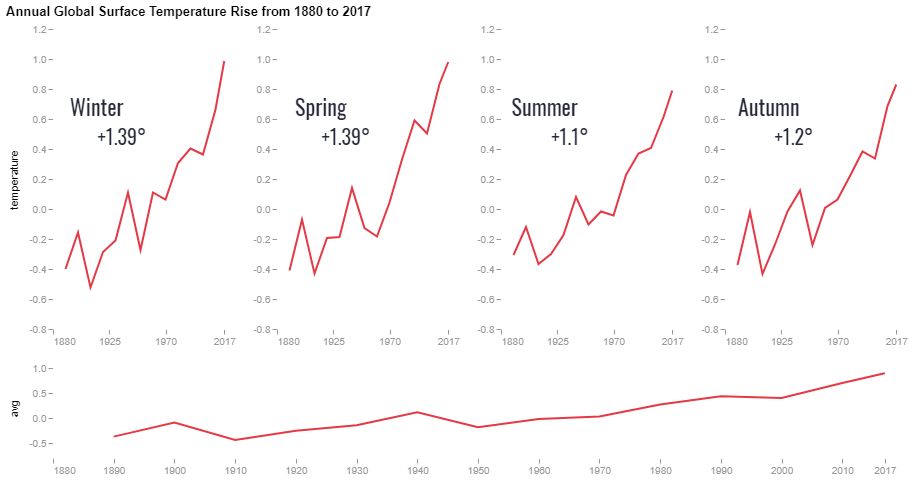

In [39]:
default_scales = {
    "years": alt.Scale(
        domain=(1880, 2020),
        clamp=True
    ),
    "temp": alt.Scale(
        domain=(-0.8, 1.2),
        clamp=True
    )
}

season_chart_config = {
    "width":175,
    "default_scales": default_scales
}

average_temp_chart_config = {
    "width":850,
    "height":100,
    "default_scales": default_scales
}

selection = alt.selection_single(on='mouseover', nearest=True, fields=['years'], empty='none')


season_charts = []
for season in ['winter', 'spring', 'summer', 'autumn']:
    season_charts.append(SeasonChart(data, selection, season, season_chart_config)())

avg_chart = AverageTempChart(data, selection, average_temp_chart_config)

top = alt.hconcat(*season_charts)
buttom = avg_chart()

final_chart = alt.vconcat(top, buttom)
final_chart.title = "Annual Global Surface Temperature Rise from 1880 to 2017"

final_chart.configure_axis(
    domainColor='#FFFFFF',
    labelColor='#999999',
    tickColor='#999999',
    grid=False
).configure_view(
    strokeWidth=0
).configure_mark(
    radius=10
).configure_axisY(
    titleFontWeight=200
)

<center> (Додана інтерактивність. Працює в .ipynb) </center>